In [122]:
BENCHMARK_TOOL = 'NVPROF' # or 'NVPROF'

import subprocess
import numpy as np
import pandas as pd
import io
from matplotlib import pyplot as plt 
from typing import Tuple

In [123]:
def read_nvprof(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[3].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

    
def read_ncu(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[2].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

def benchmark_kernel(exe_path: str, *args) -> str :
    if BENCHMARK_TOOL == 'NVPROF':
        return str(subprocess.check_output(
            ['nvprof', '--print-gpu-trace', '--csv', exe_path, *args], 
            stderr=subprocess.STDOUT
        ))
    elif BENCHMARK_TOOL == 'NCU':
        return str(subprocess.check_output(
            ['ncu','--csv', exe_path, *args], 
            stderr=subprocess.STDOUT, shell=True
        ))

def read_benchmark(output: str) -> pd.DataFrame:
    if BENCHMARK_TOOL == 'NVPROF':
        return read_nvprof(output)
    elif BENCHMARK_TOOL == 'NCU':
        return read_ncu(output)

def get_kernel_duration(df: pd.DataFrame, kernelNum=0) -> float:
    if BENCHMARK_TOOL == 'NVPROF':
        # conversion en ms 
        if df.loc[0, 'Duration'] == "ms":
            return float(df.loc[kernelNum + 1, 'Duration']) 
        if df.loc[0, 'Duration'] == "s":
            return float(df.loc[kernelNum + 1, 'Duration']) * 1e3
        # probablement en micro seconde
        return float(df.loc[kernelNum + 1, 'Duration']) * 1e-3
    elif BENCHMARK_TOOL == 'NCU':
        return float(df[df['Metric Name'] == 'Duration']['Metric Value'].to_numpy().item().replace(',','')) * 1e-6

In [124]:
kernelDurations = []
numberOfKernel = 5
for i in range(0, numberOfKernel):
    kernelDurations.append(
        get_kernel_duration(
            read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(i))), i
        ) # * 1e3
    )
print("Durée de chaque kernel:")
print(kernelDurations) # En milliseconde

Durée de chaque kernel:
[0.160063, 1.823894, 6.109025, 0.014432, 5.02653]


In [125]:
print("benchmark du kernel RGB To HSV:")
read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(0))) 

benchmark du kernel RGB To HSV:


,"""Start",Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Device,Context,Stream,Name,"Correlation_ID"""
0,ms,ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,MB,GB/s,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,287.781591,0.157279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759644,10.925819,Pageable,Device,NVIDIA GeForce RTX 2060 (0),1.0,7.0,[CUDA memcpy HtoD],118.0
2,287.949814,16.998265,32.0,1.0,1.0,1.0,1.0,1.0,21.0,0,0,NaN,NaN,NaN,NaN,NVIDIA GeForce RTX 2060 (0),1.0,7.0,"rgb2hsv(unsigned char const *, unsigned int, f...",119.0
3,',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
print("benchmark d'égaliser l'histogramme:")
out = read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(3)))
 
    
print(get_kernel_duration(out, 0))# en seconde 
print(get_kernel_duration(out, 1))
out

benchmark d'égaliser l'histogramme:
0.155231
1.819702


,"""Start",Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Device,Context,Stream,Name,"Correlation_ID"""
0,ms,ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,MB,GB/s,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,313.300683,0.155231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759644,11.069966,Pageable,Device,NVIDIA GeForce RTX 2060 (0),1.0,7.0,[CUDA memcpy HtoD],118.0
2,313.468298,1.819702,32.0,32.0,1.0,1.0,1.0,1.0,21.0,0,0,NaN,NaN,NaN,NaN,NVIDIA GeForce RTX 2060 (0),1.0,7.0,"rgb2hsv(unsigned char const *, unsigned int, f...",119.0
3,315.288640,6.102750,32.0,1.0,1.0,1.0,1.0,1.0,16.0,0,0,NaN,NaN,NaN,NaN,NVIDIA GeForce RTX 2060 (0),1.0,7.0,"histogram(float const *, unsigned int, unsigne...",120.0
4,321.392126,0.014464,32.0,1.0,1.0,1.0,1.0,1.0,33.0,0,0,NaN,NaN,NaN,NaN,NVIDIA GeForce RTX 2060 (0),1.0,7.0,"repart(unsigned int const *, unsigned int, uns...",121.0
5,321.407358,5.025381,32.0,1.0,1.0,1.0,1.0,1.0,16.0,0,0,NaN,NaN,NaN,NaN,NVIDIA GeForce RTX 2060 (0),1.0,7.0,"equalization(unsigned int const *, unsigned in...",122.0
6,',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
 
def getDuration(kernelType, nTry = 10): 
    durations = []
    sizes = []
    avg = 0
    xBlockSize, yBlockSize = 1, 1

    while xBlockSize <= 1024:
        for _ in range(nTry) :         
            avg += get_kernel_duration(read_benchmark(
                benchmark_kernel("./hist", 
                    "-f", "./img/chateau.png", 
                    "-b", str(kernelType), 
                    "-d", str(xBlockSize), str(yBlockSize)
                )
            ), kernelType)

        avg /= nTry
        durations.append(avg)    
        sizes.append(xBlockSize)
        xBlockSize *= 2
    return durations, sizes



In [128]:
# Histogramme
durations, sizes = getDuration(1)
   

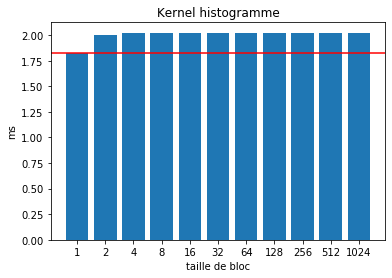

In [137]:
def histogramDurationKernel(durations, sizes, title):
    plt.title(title)  
    plt.xlabel("taille de bloc") 
    plt.ylabel("ms") 
    plt.bar(np.array(sizes).astype(str), np.array(durations), width=.8)
    plt.axhline(min(durations), ls='-', color='green')
    plt.show()
  
histogramDurationKernel(durations, sizes, "Kernel histogramme")